In [1]:
!pip install jupyterthemes
!jt -t chesterish

In [2]:
from __future__ import print_function,division
from builtins import input,range

In [3]:
import os,sys,numpy as np,pandas as pd,matplotlib.pyplot as plt
from keras.layers import Input,LSTM,Dense,Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam,SGD,RMSprop
from keras.utils import to_categorical
from keras.models import Model
import keras
import keras_applications

Using TensorFlow backend.
/home/pranjaldub1999/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pranjaldub1999/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pranjaldub1999/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pranjaldub1999/anaconda3/l

In [4]:
BATCH_SIZE =128
EPOCHS = 100
LATENT_DIM = 256
NUM_SAMPLES = 10000
MAX_SEQUENCE_LEN = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [5]:
#SENTENCE IN ORIGINAL LANGUAGE
input_texts=[]

#SENTENCE IN TARGET LANGUAGE
target_texts=[]

#SENTENCE IN TARGET LANGUAGE OFFSET BY  ONE
target_texts_input=[]



In [6]:
t=0
for line in open('hin.txt'):
    if t > NUM_SAMPLES:
        break
    if '\t' not in line:
        continue
    eng , hin , junk = line.split('\t')
    hineos = hin + ' <eos>'
    hinsos = '<sos> ' + hin
    
    input_texts.append(eng)
    target_texts_input.append(hinsos)
    target_texts.append(hineos)
print(input_texts[998])
print(target_texts[998])
print(target_texts_input[998])
assert '<sos>' in target_texts_input[1]

He often plays the guitar.
वह अक्सर गिटार बजाता है। <eos>
<sos> वह अक्सर गिटार बजाता है।


In [7]:
#TOKENIZATION of input
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)
word2idx_input = tokenizer_inputs.word_index
print(len(word2idx_input))
#max length input
max_len_input = max(len(s) for s in input_sequences)
print(max_len_input)


#TOKENIZATION OF OUTPUT (BOTH WITH SOS AND EOS TOKEN)
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS,filters = '')
targets_combined = target_texts + target_texts_input
tokenizer_outputs.fit_on_texts(targets_combined)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_input)
word2idx_output = tokenizer_outputs.word_index
print(len(word2idx_output))
#print(word2idx_output['<sos>']) #######isme sos find nhi kr paa rha############
#max length target
max_len_output = max(len(s) for s in target_sequences)
for k,v in word2idx_output.items():
    if k == '<sos>':
        print("sos found at idx",v)
    if k == '<eos>':
        print("eos found at idx",v)
    else:
        continue

2375
22
3117
eos found at idx 1
sos found at idx 2


In [8]:
#PADDING 

#padding for encoder inputs
encoder_inputs_padded = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder input shape",encoder_inputs_padded.shape)
print("encoder_data[0]",encoder_inputs_padded[0])

#padding for decoder teacher forcing input
decoder_inputs_padded = pad_sequences(target_sequences_inputs, maxlen=max_len_output,padding = 'post')
print("decoder input shape" , decoder_inputs_padded.shape)
print("decoder_data[0]" , decoder_inputs_padded)

#padding for decoder target
decoder_target_padded = pad_sequences(target_sequences,maxlen=max_len_output , padding = 'post')
print("decoder target  shape" , decoder_target_padded.shape)
print("decoder_target_data[0]" , decoder_target_padded[0])

encoder input shape (2778, 22)
encoder_data[0] [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 1264]
decoder input shape (2778, 26)
decoder_data[0] [[   2 1477    0 ...    0    0    0]
 [   2 1478    0 ...    0    0    0]
 [   2 1479    0 ...    0    0    0]
 ...
 [   2 3109  753 ...    0    0    0]
 [   2  138   60 ...    0    0    0]
 [   2  132    7 ...    5   26  153]]
decoder target  shape (2778, 26)
decoder_target_data[0] [1477    1    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [9]:
#LOADING PRETRAINED WORD VECTORS
print("loading vectors broo")
word2vec = {}
with open(os.path.join('glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:],dtype='float32')
        word2vec[word] = vec
print("length of word2vec" , len(word2vec))

loading vectors broo
length of word2vec 400000


In [10]:
#EMBEDDING MATRIX
print("filling pretrained matrix...hold on a sec....Done!")
num_words = min(MAX_NUM_WORDS,len(word2idx_input)+1)
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word , i in word2idx_input.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

filling pretrained matrix...hold on a sec....Done!


In [11]:
#EMBEDDING LAYER
embedding_layer = Embedding(num_words,EMBEDDING_DIM,weights = [embedding_matrix],input_length=max_len_input,trainable = True)

In [12]:
num_words_output = len(word2idx_output)+1

In [13]:
#CREATING ONE HOT TARGETS since we cant use sparse_categorical_crossentropy for sequence data
decoder_targets_one_hot = np.zeros((len(input_texts),max_len_output,num_words_output),dtype = 'float32')
for i , d in enumerate(decoder_target_padded):
    for t,word in enumerate(d):
        decoder_targets_one_hot[i,t,word] = 1

In [14]:
#BUILD THE MODEL (TRAINING)

#ENCODER MODEL FOR TRAINING
encoder_inputs_placeholder = Input(shape = (max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder =  LSTM(LATENT_DIM,return_state=True,return_sequences=False,recurrent_dropout=0.5)
encoder_outputs , h , c = encoder(x)
encoder_states = [h,c]


#DECODER MODEL FOR TEACHER FORCING TRAINING
decoder_inputs_placeholder = Input(shape = (max_len_output,))
#the embedding will not use the pretrained embeddings, so creating the new embedding layer
decoder_embedding = Embedding(num_words_output,EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
decoder_lstm = LSTM(LATENT_DIM,return_sequences=True,return_state=True,recurrent_dropout=0.5)
decoder_outputs, _,_= decoder_lstm(decoder_inputs_x,initial_state = encoder_states)
decoder_dense = Dense(num_words_output , activation = 'softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs_placeholder,decoder_inputs_placeholder],decoder_outputs)
model.compile(optimizer = Adam(lr = 0.001),loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 22)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 22, 100)      237600      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 26, 100)      311800      input_2[0][0]                    
____________________________________________________________________________________________

In [15]:
r = model.fit([encoder_inputs_padded,decoder_inputs_padded],decoder_targets_one_hot,batch_size=BATCH_SIZE,
             epochs=EPOCHS,validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 2222 samples, validate on 556 samples
Epoch 1/100
2222/2222 [==============================] - 16s 7ms/step - loss: 5.3720 - accuracy: 0.6875 - val_loss: 3.2774 - val_accuracy: 0.5813
Epoch 2/100
2222/2222 [==============================] - 16s 7ms/step - loss: 1.8598 - accuracy: 0.7303 - val_loss: 3.1953 - val_accuracy: 0.5813
Epoch 3/100
2222/2222 [==============================] - 16s 7ms/step - loss: 1.7356 - accuracy: 0.7303 - val_loss: 3.0743 - val_accuracy: 0.5813
Epoch 4/100
2222/2222 [==============================] - 16s 7ms/step - loss: 1.6832 - accuracy: 0.7361 - val_loss: 3.0750 - val_accuracy: 0.5845
Epoch 5/100
2222/2222 [==============================] - 16s 7ms/step - loss: 1.6477 - accuracy: 0.7403 - val_loss: 3.0475 - val_accuracy: 0.5854
Epoch 6/100
2222/2222 [==============================] - 16s 7ms/step - loss: 1.6124 - accuracy: 0.7427 - val_loss: 2.9751 - val

2222/2222 [==============================] - 18s 8ms/step - loss: 0.8604 - accuracy: 0.8299 - val_loss: 2.6705 - val_accuracy: 0.6432
Epoch 53/100
2222/2222 [==============================] - 18s 8ms/step - loss: 0.8461 - accuracy: 0.8327 - val_loss: 2.6766 - val_accuracy: 0.6437
Epoch 54/100
2222/2222 [==============================] - 19s 9ms/step - loss: 0.8305 - accuracy: 0.8343 - val_loss: 2.6620 - val_accuracy: 0.6447
Epoch 55/100
2222/2222 [==============================] - 20s 9ms/step - loss: 0.8160 - accuracy: 0.8365 - val_loss: 2.6763 - val_accuracy: 0.6450
Epoch 56/100
2222/2222 [==============================] - 20s 9ms/step - loss: 0.8015 - accuracy: 0.8388 - val_loss: 2.6770 - val_accuracy: 0.6467
Epoch 57/100
2222/2222 [==============================] - 19s 8ms/step - loss: 0.7871 - accuracy: 0.8414 - val_loss: 2.6745 - val_accuracy: 0.6456
Epoch 58/100
2222/2222 [==============================] - 19s 9ms/step - loss: 0.7726 - accuracy: 0.8438 - val_loss: 2.6773 - val_a

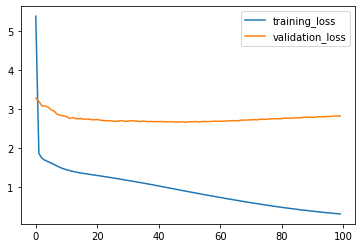

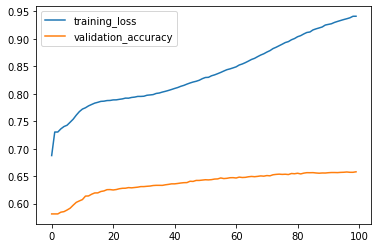

In [16]:
plt.plot(r.history['loss'],label = 'training_loss')
plt.plot(r.history['val_loss'],label = 'validation_loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'],label = 'training_loss')
plt.plot(r.history['val_accuracy'],label = 'validation_accuracy')
plt.legend()
plt.show()

NOW WE WILL USE THE PREVIOUSLY TRAINED ENCODER MODEL AND CREATE A DECODER MODEL THAT GENERATES TEXT AFTER TAKING ENCODER INITIAL STATES AND ACCEPTING SEQUENCE LENGTH OF 1

In [17]:
#LOADING ENCODER MODEL
encoder_model = Model(encoder_inputs_placeholder,encoder_states)


In [18]:
decoder_states_input_h = Input(shape = (LATENT_DIM,))
decoder_states_input_c = Input(shape = (LATENT_DIM,))
decoder_states_inputs = [decoder_states_input_h ,decoder_states_input_c]
decoder_inputs_single = Input(shape = (1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)
decoder_outputs,h,c = decoder_lstm(decoder_inputs_single_x,initial_state=decoder_states_inputs)
print("h",h.shape)
print("c",c.shape)
print("decoder_inputs_single", decoder_inputs_single)
decoder_states = [h,c]
decoder_outputs = decoder_dense(decoder_outputs)

#INITIALIZING THE DECODER MODEL
decoder_model = Model([decoder_inputs_single]+decoder_states_inputs,
                     [decoder_outputs]+decoder_states)

h (?, 256)
c (?, 256)
decoder_inputs_single Tensor("input_5:0", shape=(?, 1), dtype=float32)


In [19]:
#REVERSE IDX TO WORD MAPPING
idx2word_eng = {v:k for k,v in word2idx_input.items()}
idx2word_tran = {v:k for k,v in word2idx_output.items()}


In [20]:
#SAMPLING FUNCTION
#def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    #create empty decoder input
    target_seq = np.zeros((1,1))
    #fill the first pos of decoder input with sos token as we will input sos and encoder states in decoder
    target_seq[0,0] = word2idx_output['<sos>']
    eos = word2idx_output['<eos>']
    #creating the translation
    output_sentence = []
    for _ in range(max_len_output):
        out,h,c = decoder_model.predict([target_seq]+states_value)
        #extract word with highest probability
        idx = np.argmax(out[0,0,:])
        if eos == idx:
            break
        word = ''
        if idx>0:
            word = idx2word_tran[idx]
            output_sentence.append(word)
        #update the decoder input for the next cell
        target_seq[0,0] = idx
        #update the states too
        states_value = [h,c]
    return ' '.join(output_sentence)

IndentationError: unexpected indent (<ipython-input-20-22a775fe06ca>, line 3)

In [ ]:
#TEST TRANSLATIONS::
#while True:
    i = np.random.choice(len(input_texts))
    input_seq = encoder_inputs_padded[i:i+1]
    print(input_seq)
    print("shape",input_seq.shape)
    translation = decode_sequence(input_seq)
    print('_')
    print("input",input_texts[i])
    print("translation" , translation)
    
    ans = input("continue y/n ?")
    if ans and ans.lower().startswith('n'):
        break

In [32]:
#SAMPLING FUNCTION #FOR CUSTOM INPUT
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    #create empty decoder input
    target_seq = np.zeros((1,1))
    #fill the first pos of decoder input with sos token as we will input sos and encoder states in decoder
    target_seq[0,0] = word2idx_output['<sos>']
    eos = word2idx_output['<eos>']
    #creating the translation
    output_sentence = []
    for _ in range(max_len_output):
        out,h,c = decoder_model.predict([target_seq]+states_value)
        #extract word with highest probability
        idx = np.argmax(out[0,0,:])
        if eos == idx:
            break
        word = ''
        if idx>0:
            word = idx2word_tran[idx]
            output_sentence.append(word)
        #update the decoder input for the next cell
        target_seq[0,0] = idx
        #update the states too
        states_value = [h,c]
    return ' '.join(output_sentence)

In [ ]:
#FOR CUSTOM INPUT   ######NOT WORKING######
while True:
    i = input()
    tokenizer_inputs_custom =tokenizer_inputs.texts_to_sequences(i)
    decoder_inputs_padded_custom = pad_sequences(tokenizer_inputs_custom, maxlen=max_len_input)
    #print(input_sequences_custom)
    #print("shape of tokens",tokenizer_inputs_custom.shape)
    print("shape of padded custom input",decoder_inputs_padded_custom)
    translation = decode_sequence(decoder_inputs_padded_custom)
    print('_')
    print("input",i)
    print("translation" , translation)
    
    ans = input("continue y/n ?")
    if ans and ans.lower().startswith('n'):
        break

he is doing his job.
shape of padded custom input [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    2]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0 2184]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    